In [665]:
%pylab inline
import pandas as pd
import seaborn as sns
import os
import pickle
# compare running with  / without lateral inhibition
epochs = 300
n_options = 0
names = []
perfs = []
n_gpus = 4
cur_gpu = 0
debug_me = False
#short_trials = 10
experiment_name = 'medium'
if experiment_name=='quick':
    short_trials = 1
    trials = range(5)
elif experiment_name == 'medium':
    trials=[0]
    short_trials = 20
else:
    short_trials=-1
    trials = [0]
mode_ = 'local'

# another version : 5 short trials, each with 1 epoch.

cmds_group_gpus = dict((i,[]) for i in range(n_gpus))
all_cmds = []

from itertools import product

#trials = [0,1,2,3]

laterals = ['none','default','rand','full']#,'none'] # included not, but now we're only trying to fix some stuff.
let_inhibition_learns = [False,True]
the_archs = ['dense','wrn']
datasets = ['10','100']
to_repeats = [False,True]
cur_suffix = '_with_repeats'
#cur_suffix = ''
all_opts = list(product(trials,laterals,let_inhibition_learns,the_archs,datasets,to_repeats))
opts_list = []
min_params_per_dataset = {}
for trial,lateral,let_inhibition_learn,the_arch,dataset,to_repeat in all_opts:
    
    if the_arch == 'dense':# or dataset == '10':
        continue
    #if the_arch!='dense' or dataset!='10':
    #    continue
    if lateral=='none' and let_inhibition_learn: 
        # nothing to learn where there's no "inhibition"
        continue
    # no need to repeat, if the inhibition was full, or none.
    if lateral in ['none','full'] and to_repeat:
        continue
    if the_arch == 'dense':
        curOutDir = '~/checkpoints/cifar{}_inhibition/densenet-bc-100-12-IN_{}_IL_{}-run_{}'
        epochs = 300
    elif the_arch == 'wrn':
        curOutDir = '~/checkpoints/cifar{}_inhibition/wrn-28-10-IN_{}_IL_{}-run_{}'
        epochs = 200
    else:
        raise Exception('unsupported arch',the_arch)
    
    if debug_me:
        epochs=1
    if short_trials != -1:
        epochs = short_trials
        curOutDir+='_S{}'.format(short_trials)
    else:
        curOutDir+='_FULL'
    if to_repeat:
        curOutDir+='_R'
    curOutDir+=cur_suffix
    
    if to_repeat:
        lateral+='_True'
    curOutDir = curOutDir.format(dataset,lateral,let_inhibition_learn,trial)
    ff = os.path.join(curOutDir,'log.txt')
#                   print ff
    #print ff
    #if mode_ == 'local' and os.path.isfile(os.path.expanduser(ff)):
    #    continue
    ff = os.path.expanduser(ff)
    cur_opts_dict = dict(trial=trial,lateral=lateral,let_inhibition_learn=let_inhibition_learn,
                          the_arch=the_arch,dataset=dataset,to_repeat=to_repeat,epochs=epochs,short_trials=short_trials)
    
    if the_arch == 'dense':
        cmd = 'python cifar.py -a densenet --depth 100 --growthRate 12\
        --train-batch 64 --epochs {epochs} --schedule 150 225 --wd 1e-4\
        --gamma 0.1 --checkpoint {checkpoint}\
        --lateral-inhibition {lateral} --learn-inhibition {let_inhibition_learn} --dataset cifar{dataset} --quit-if-exists True'.format(epochs=epochs,
        checkpoint=curOutDir,
        lateral=lateral,
        let_inhibition_learn=let_inhibition_learn,dataset=dataset)
    elif the_arch == 'wrn':
        #python cifar.py -a wrn --depth 28 --depth 28 --widen-factor 10 --drop 0.3 --epochs 200 --schedule 60 120 160 --wd 5e-4 --gamma 0.2 --checkpoint checkpoints/cifar10/WRN-28-10-drop
        cmd = 'python cifar.py -a wrn --depth 28 --widen-factor 10\
        --drop 0.3 --epochs {epochs} --schedule 60 120 160 --wd 5e-4\
        --gamma 0.2 --checkpoint {checkpoint}\
        --lateral-inhibition {lateral} --learn-inhibition {let_inhibition_learn} --dataset cifar{dataset} --quit-if-exists True'.\
        format(epochs=epochs,
        checkpoint=curOutDir,
        lateral=lateral,
        let_inhibition_learn=let_inhibition_learn,dataset=dataset)
    cur_opts_dict['cmd'] = cmd
    n_params = 0
    paramCountPath = ff.replace('log.txt','n_params.txt')
    if True and os.path.isfile(os.path.expanduser(ff)):
        #print 'dfgdf'
        names.append('{}_{}_{}_{}'.format(lateral,let_inhibition_learn,trial,'cifar'+dataset))
        p = []
        #print lateral, let_inhibition_learn
        lines = open(ff).readlines()
        
        #print len(lines)
        for k in lines[1:]:
            #print k
            p.append(float(k.split()[-1]))
        perfs.append(p)
        n_params = open(paramCountPath).readlines()        
        n_params = [int(q.strip().split()[-1]) for q in n_params]
        cur_opts_dict['active_params'] = n_params[0]
        cur_opts_dict['total_params'] = n_params[1]
        #if dataset=='100':
        #    print '!!!!!!!!!111'
        if lateral=='none' and let_inhibition_learn==False and to_repeat == False:
            min_params_per_dataset[dataset] = n_params[1]
        
        if len(p) == 0:
            cur_opts_dict['perf']=-1
        else:
            cur_opts_dict['perf'] = p[-1]
        opts_list.append(cur_opts_dict)
    else:
        print '!'
        #break
        cur_opts_dict['perf']=-1
        
        #print p[-1]
        #print '!!!!!!!!!!!!!!'
        #print len(lines)
        #if len(lines)>=epochs+1:
        #    pass
        #else:
        #    print len(lines)
    n_options+=1
    

    #print cmd
    
    
    
    
    cmds_group_gpus[cur_gpu].append(cmd)
    cur_gpu+=1
    if cur_gpu == n_gpus:
        cur_gpu=0
    all_cmds.append(dict(cmd=cmd,epochs=epochs))
print n_options

Populating the interactive namespace from numpy and matplotlib
22


In [666]:
df1=pd.DataFrame(opts_list)
for dataset in ['10','100']:
    print '...'
    df1.loc[df1.dataset==dataset,'total_params']-=min_params_per_dataset[dataset]   
#df1 = df1[df1.perf>0]
df1.sort_values('total_params')

del df1['epochs']
del df1['short_trials']
del df1['trial']
#df1 = df1[['dataset','lateral','let_inhibition_learn', 'to_repeat','total_params','perf']]

df1=df1.groupby(['dataset','lateral','let_inhibition_learn','to_repeat'],as_index=False).mean().sort_values('perf',ascending=False)#,ascending=False)
#df2[['dataset','lateral','to_repeat','total_params','perf']]
df1[df1.dataset=='10']

...
...


,dataset,lateral,let_inhibition_learn,to_repeat,active_params,perf,total_params
4,10,full,False,False,36479194,85.77,38709504
1,10,default,True,False,36559978,84.95,80784
8,10,rand,True,False,36559978,84.40,80784
7,10,rand,False,False,36479194,82.89,80784
6,10,none,False,False,36479194,82.73,0
10,10,rand_True,True,True,36479419,82.71,225
3,10,default_True,True,True,36479419,82.28,225
0,10,default,False,False,36479194,79.47,80784
5,10,full,True,False,75188698,79.04,38709504
2,10,default_True,False,True,36479194,77.27,225


In [641]:
min_params_per_dataset

{'10': 36479194, '100': 36536884}

In [642]:
for p in all_cmds:
    print p['cmd']
print

python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_none_IL_False-run_0_S1_with_repeats        --lateral-inhibition none --learn-inhibition False --dataset cifar10 --quit-if-exists True
python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar100_inhibition/wrn-28-10-IN_none_IL_False-run_0_S1_with_repeats        --lateral-inhibition none --learn-inhibition False --dataset cifar100 --quit-if-exists True
python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_False-run_0_S1_with_repeats        --lateral-inhibition default --learn-inhibition False --dataset cifar10 --quit-if-exists True
python cifar.py -

In [643]:
df1=pd.DataFrame(opts_list)
df1[(df1.dataset=='10') &(df1.to_repeat==True)].iloc[0].cmd

'python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_True_IL_False-run_0_S1_R_with_repeats        --lateral-inhibition default_True --learn-inhibition False --dataset cifar10 --quit-if-exists True'

In [644]:
def makeCommand(requiredFile,command,n_required_lines=-1):
    #cmd=outPath = os.path.join(all_cmds[0].split()[-7],'log.txt')
    if n_required_lines==-1:
        cmd= \
        'FILE={} \n \
        if [ -d $FILE ]; then \n\
           echo "File $FILE exists." \n\
        else\n\
           echo "File $FILE does not exist." \n\
           {} \n \
        fi'.format(requiredFile,command)        
    else:
        cmd= \
        'FILE={} \n \
        if [[ -d $FILE ]] && [[ $(wc -l <$FILE/log.txt) -ge {} ]]; then \n\
           echo "Directory $FILE and full log file exists." \n\
        else\n\
           echo "Does not  exist - running command ." \n\
           {} \n \
        fi'.format(requiredFile,n_required_lines,command)
        
    return cmd

theChunks = map(list,np.array_split(all_cmds,n_gpus))

for i,chunk in enumerate(theChunks):
    #chunk = chunk[:1]
    print '(',
    for ii,c_ in enumerate(chunk):
        #c = 'touch {}'.format(str(ii).zfill(5))\
        c = c_['cmd']
        epochs=c_['epochs']
        required_file = c.split()[-7]
        command_stuff = '{} --gpu_id {}'.format(c,i)
        cmd = makeCommand(required_file,command_stuff,epochs)
        print cmd,
        if ii < len(chunk)-1:
            print ' ;',        
    print ') &'

( FILE=none 
         if [[ -d $FILE ]] && [[ $(wc -l <$FILE/log.txt) -ge 1 ]]; then 
           echo "Directory $FILE and full log file exists." 
        else
           echo "Does not  exist - running command ." 
           python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_none_IL_False-run_0_S1_with_repeats        --lateral-inhibition none --learn-inhibition False --dataset cifar10 --quit-if-exists True --gpu_id 0 
         fi  ; FILE=none 
         if [[ -d $FILE ]] && [[ $(wc -l <$FILE/log.txt) -ge 1 ]]; then 
           echo "Directory $FILE and full log file exists." 
        else
           echo "Does not  exist - running command ." 
           python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 1 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar100_inhibition/wrn-28-10-IN_none_I

In [191]:
# Trying to train locally, with yellowfin, and a different shedule.
cmd = 'python cifar.py -a wrn --depth 28 --widen-factor 10 --lr {lr} --drop 0.3 --epochs 100 --schedule {schedule} --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_rand_IL_True-run_0_FULL_{optimizer} --lateral-inhibition rand --learn-inhibition True --dataset cifar10  --gpu_id 0 --optimizer {optimizer}'
print cmd.format(schedule='60 120 160',optimizer='YF',lr=0.1)


python cifar.py -a wrn --depth 28 --widen-factor 10 --lr 0.1 --drop 0.3 --epochs 100 --schedule 30 60 80 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_rand_IL_True-run_0_FULL_YF --lateral-inhibition rand --learn-inhibition True --dataset cifar10  --gpu_id 0 --optimizer YF


In [193]:
cmd = 'python cifar.py -a wrn --depth 28 --widen-factor 10 --lr {lr} --drop 0.3 --epochs 100 --schedule {schedule} --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_rand_IL_True-run_0_{optimizer} --lateral-inhibition rand --learn-inhibition True --dataset cifar10  --gpu_id 0 --optimizer {optimizer}'
print cmd.format(schedule='10',optimizer='adam',lr=0.001)





python cifar.py -a wrn --depth 28 --widen-factor 10 --lr 0.001 --drop 0.3 --epochs 100 --schedule 10 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_rand_IL_True-run_0_adam --lateral-inhibition rand --learn-inhibition True --dataset cifar10  --gpu_id 0 --optimizer adam


In [ ]:
python cifar.py -a wrn --depth 28 --widen-factor 10 --lr 0.001 --drop 0.3 --epochs 100 --schedule 30 60 80 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_rand_IL_True-run_0_FULL_ADAM        --lateral-inhibition rand --learn-inhibition True --dataset cifar10  --gpu_id 0

In [142]:
# just print the commands, use all gpus simultaneously

for z in all_cmds:
    break
command_stuff = '{} --gpu_id {}'.format(z['cmd'],'1,2,3,4')
command_stuff
    


'python cifar.py -a wrn --depth 28 --widen-factor 10        --drop 0.3 --epochs 200 --schedule 60 120 160 --wd 5e-4        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_False-run_0_FULL        --lateral-inhibition default --learn-inhibition False --dataset cifar10  --gpu_id 1,2,3,4'

In [12]:
#%qtconsole

In [13]:
# analyze short experiments

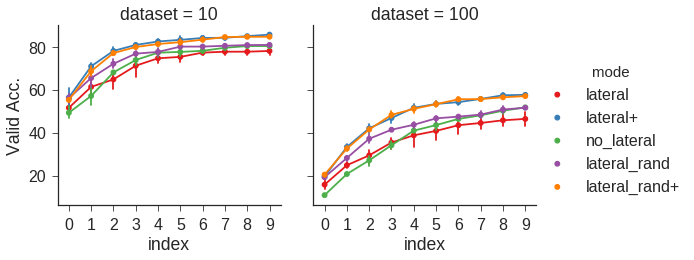

In [243]:
#for my_arch in ['dense','wrn']:
applyCummax=True
for my_arch in ['wrn']:#,'dense']:
    a = pickle.load(open('/home/amir/Downloads/results.pkl'))
    from StringIO import StringIO
    z = []
    for aa in a:
        theTable = L = '\n'.join(map(str.strip,aa['flines']))
        aa_table = pd.read_table(StringIO(L)).reset_index()
        aa_table['arch']=aa['arch']
        if applyCummax:
            aa_table['Valid Acc.'] = aa_table['Valid Acc.'].cummax()
        if aa['arch']!=my_arch:
            continue
        #if aa['dataset']=='100':
        #    continue

        s = ''
        lll = aa['lateral']
        if lll=='none':
            s = 'no_lateral'
        elif lll=='default':
            s = 'lateral'
        elif lll=='rand':
            s = 'lateral_rand'
        if aa ['let_inhibition_learn']:
            s+='+'
        aa_table['mode'] = s        
        aa_table['let_inhibition_learn']=aa['let_inhibition_learn']
        aa_table['let_inhibition_learn']=aa['let_inhibition_learn']
        aa_table['lateral']=aa['lateral']
        aa_table['dataset']=aa['dataset']
        aa_table['trial']=aa['trial']

        z.append(aa_table)
        #z.append(aa_table)#[-50:])
        #break
    if len(z)==0:
        continue
    z = pd.concat(z)
    sns.set_style("ticks")
    sns.set_context('paper',font_scale=2,rc={'lines.linewidth': 1})#,'lines.markeredgewidth':10})
    sns.set_palette(sns.color_palette("Set1", n_colors=5, desat=1))
    g=sns.factorplot(data=z,x='index',y='Valid Acc.',col='dataset',hue='mode')#,linestyles='-')#,
    
    #g=sns.factorplot(data=z,x='index',y='Valid Acc.',col='dataset',hue='mode',aspect=1)
    #suptitle(my_arch)
    #(data=aa_table[::10],x='index',y='Valid Acc.',aspect=2)
    #g.set(xticklabels=[])
#
    

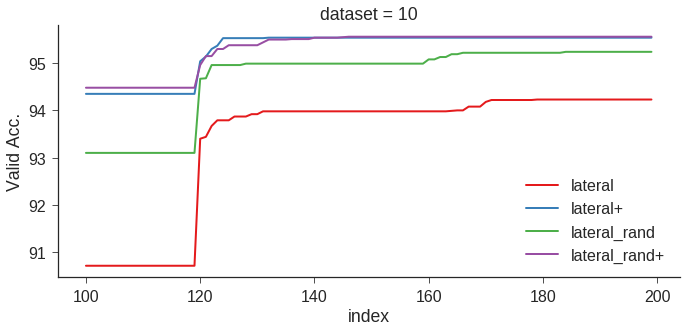

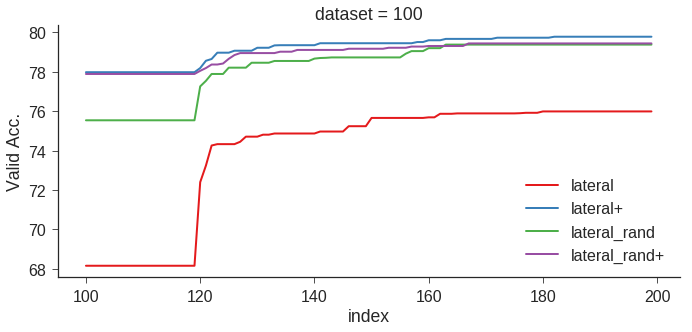

In [241]:
#for my_arch in ['dense','wrn']:
my_arch = 'wrn'
sampling=1
a = pickle.load(open('/home/amir/Downloads/results_full.pkl'))
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')
from StringIO import StringIO
z = []
for aa in a:
    flines=aa['flines']
    #if len(flines) < 200:
    #    continue
    theTable = L = '\n'.join(map(str.strip,flines))
    aa_table = pd.read_table(StringIO(L)).reset_index()
    aa_table['arch']=aa['arch']
    if aa['arch']!=my_arch:
        continue
    if applyCummax:
        aa_table['Valid Acc.'] = aa_table['Valid Acc.'].cummax()
    #if aa['dataset']=='100':
    #    continue
    #aa_table = aa_table[::sampling]
    s = ''
    lll = aa['lateral']
    if lll=='none':
        s = 'no_lateral'
    elif lll=='default':
        s = 'lateral'
    elif lll=='rand':
        s = 'lateral_rand'
    if aa ['let_inhibition_learn']:
        s+='+'
    aa_table['mode'] = s        
    aa_table['let_inhibition_learn']=aa['let_inhibition_learn']    
    aa_table['lateral']=aa['lateral']
    aa_table['dataset']=aa['dataset']
    aa_table['trial']=aa['trial']
    z.append(aa_table)
z = pd.concat(z)
close()
sns.set_palette(sns.color_palette("Set1", n_colors=4, desat=1))
min_index=100
for dataset in ['10','100']:    
    g = sns.FacetGrid(data=z[(z.dataset==dataset) & (z.index >=min_index)],col='dataset',hue='mode',size=5,aspect=2)
    g = g.map_dataframe(plt.plot,'index', 'Valid Acc.',linewidth=2,linestyle='-')
    #ylim([90,97])    
    
    legend()

In [195]:
z.sort_values('Valid Acc.',ascending=False)

,index,Learning Rate,Train Loss,Valid Loss,Train Acc.,Valid Acc.,arch,mode,let_inhibition_learn,lateral,dataset,trial
195,195,0.0008,0.001933,0.189077,99.996,95.56,wrn,lateral_rand+,True,rand,10,0
169,169,0.0008,0.001984,0.185728,99.994,95.56,wrn,lateral_rand+,True,rand,10,0
167,167,0.0008,0.002092,0.186337,99.990,95.56,wrn,lateral_rand+,True,rand,10,0
166,166,0.0008,0.002261,0.186789,99.986,95.56,wrn,lateral_rand+,True,rand,10,0
165,165,0.0008,0.002264,0.187530,99.990,95.56,wrn,lateral_rand+,True,rand,10,0
164,164,0.0008,0.002334,0.188098,99.984,95.56,wrn,lateral_rand+,True,rand,10,0
163,163,0.0008,0.002397,0.188109,99.988,95.56,wrn,lateral_rand+,True,rand,10,0
162,162,0.0008,0.002588,0.189822,99.978,95.56,wrn,lateral_rand+,True,rand,10,0
161,161,0.0008,0.002801,0.190099,99.976,95.56,wrn,lateral_rand+,True,rand,10,0
160,160,0.0008,0.003413,0.190810,99.952,95.56,wrn,lateral_rand+,True,rand,10,0


In [171]:
a[0]['dataset']

'10'

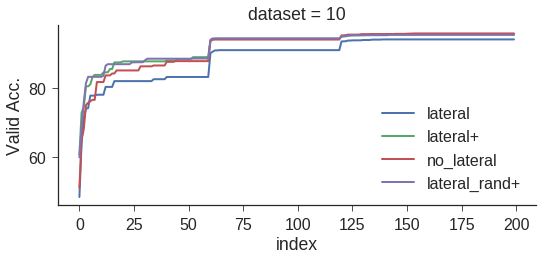

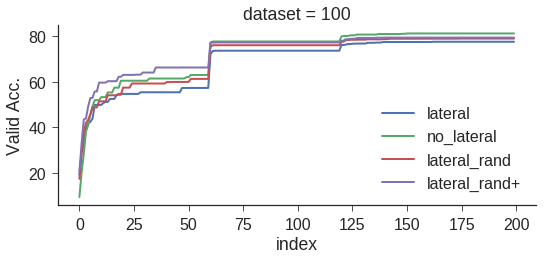

In [119]:
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')
for dataset in ['10','100']:    
    g = sns.FacetGrid(data=z[z.dataset==dataset],col='dataset',hue='mode',size=4,aspect=2)
    g = g.map_dataframe(plt.plot,'index', 'Valid Acc.',linewidth=2,linestyle='-')
    #ylim([0,100])
    legend()

In [132]:
aa_table = pd.read_table(StringIO(L))


201

In [135]:
z[z.dataset=='10'].sort_values('Valid Acc.')

,Learning Rate,Train Loss,Valid Loss,Train Acc.,Valid Acc.,arch,n_iters,mode,let_inhibition_learn,lateral,dataset,trial
43,0.100,0.338845,0.419944,88.342,85.97,wrn,53,lateral_rand,False,rand,10,0
139,0.004,0.009988,0.213510,99.818,94.26,wrn,200,lateral,False,default,10,0
142,0.004,0.002568,0.176612,99.976,95.59,wrn,200,lateral_rand+,True,rand,10,0
133,0.004,0.002919,0.172942,99.972,95.73,wrn,200,lateral+,True,default,10,0
153,0.004,0.003139,0.164361,99.972,96.00,wrn,200,no_lateral,False,none,10,0


In [98]:
#z.dataset.unique

0      100
10     100
20     100
30     100
40     100
50     100
60     100
70     100
80     100
90     100
100    100
110    100
120    100
130    100
140    100
150    100
160    100
170    100
180    100
190    100
0       10
10      10
20      10
30      10
40      10
50      10
60      10
70      10
80      10
90      10
      ... 
100    100
110    100
120    100
130    100
140    100
150    100
160    100
170    100
180    100
190    100
0       10
10      10
20      10
30      10
40      10
50      10
60      10
70      10
80      10
90      10
100     10
110     10
120     10
130     10
140     10
150     10
160     10
170     10
180     10
190     10
Name: dataset, Length: 172, dtype: object

In [244]:
import torch
from torch import nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.nn import Parameter
class LateralInhibition(nn.Module):
    def __init__(self, aConv, lateral_inhibition='none',learnable=False,filter_size=3):
        super(LateralInhibition, self).__init__()
        # for now, support just one kind of inhibition.
        self.lateral_inhibition = lateral_inhibition
        out_channels = aConv.weight.shape[0]
        if lateral_inhibition=='none':
            print 'not doing any inhibition'
            self.my_fun = nn.Sequential()
        elif lateral_inhibition in ['rand','default']:
            # Implement as a grouped convolution.
            myConv = nn.Conv2d(out_channels, out_channels, (filter_size, filter_size), padding=1, groups=out_channels, bias=False)
            if lateral_inhibition == 'rand': # random init, learn as usual
                pass
            elif lateral_inhibition == 'default': #initialized with preset filter.
                #f = torch.zeros(3, 3)
                #f[1, 1] = 1
                basic_m = torch.zeros(3, 3)
                basic_m[1, 1] = 1
                basic_m -= basic_m.mean()
                myConv.weight.data = basic_m.expand_as(myConv.weight.data)

            #f = torch.zeros(out_channels, 1, 3, 3)
            #myConv.weight.requires_grad=learnable
            self.my_fun = myConv
        elif lateral_inhibition == 'full':
            myConv = nn.Conv2d(out_channels, out_channels, (filter_size, filter_size), padding=1, groups=out_channels,
                               bias=False)
            self.my_fun = nn.Conv2d(out_channels, out_channels, (filter_size, filter_size), padding=1,  bias=False)
        #else:
        #    raise Exception('unexpected type',lateral_inhibition,'for lateral inhibition')

        for p in self.my_fun.parameters():
            p.requires_grad=learnable

    def forward(self, x):
        #print('LATERAL, size of input:',x.shape,'size of weights:',self.my_fun.weight.shape)
        return self.my_fun(x)


In [308]:
from torch import nn
aConv = nn.Conv2d(16,16,3)
filter_size=3
out_channels = aConv.weight.shape[0]
print 'out channels:',out_channels
print 'size of weights',aConv.weight.shape
myConv = nn.Conv2d(out_channels, out_channels, (filter_size, filter_size), padding=1, groups=out_channels, bias=False)
print 'myConv.weight.shape:',myConv.weight.shape

basic_m = torch.zeros(3, 3)
basic_m[1, 1] = 1
basic_m -= basic_m.mean()
v=Variable(basic_m)
print 'v.shape',v.shape


out channels: 16
size of weights torch.Size([16, 16, 3, 3])
myConv.weight.shape: torch.Size([16, 1, 3, 3])
v.shape torch.Size([3, 3])


In [273]:
v[0,0]=9

In [274]:
v.repeat(16,1,1,1)[3]

Variable containing:
(0 ,.,.) = 
  9.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111
[torch.FloatTensor of size (1,3,3)]

In [292]:
v.expand?

torch.Size([3, 3])

In [377]:
v= Variable(basic_m).expand(16,1,3,3)
v[:2]

Variable containing:
(0 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(1 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111
[torch.FloatTensor of size (2,1,3,3)]

In [378]:
v

Variable containing:
(0 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(1 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(2 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(3 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(4 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(5 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(6 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(7 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(8 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(9 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(10,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.

In [316]:
nn.functional.conv2d?

In [313]:
v[0,0,0,0]

Variable containing:
-0.1111
[torch.FloatTensor of size (1,)]

In [315]:
v[0,0,0,0]=1
v

Variable containing:
(0 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(1 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(2 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(3 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(4 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(5 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(6 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(7 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(8 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(9 ,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.1111 -0.1111 -0.1111

(10,0 ,.,.) = 
  1.0000 -0.1111 -0.1111
 -0.1111  0.8889 -0.1111
 -0.

In [108]:

.idxmax()['Valid Acc.']

TypeError: reduction operation 'argmax' not allowed for this dtype

In [105]:
z.loc[list(z.groupby(['dataset']).idxmax()['Valid Acc.'])]

,Learning Rate,Train Loss,Valid Loss,Train Acc.,Valid Acc.,arch,mode,let_inhibition_learn,lateral,dataset,trial
150,0.004,0.023689,0.940376,99.768,76.89,wrn,lateral,False,default,100,0
150,0.004,0.008911,0.226923,99.856,93.98,wrn,lateral,False,default,10,0
150,0.004,0.003354,0.184834,99.956,95.36,wrn,lateral+,True,default,10,0
150,0.004,0.011017,0.775192,99.922,81.11,wrn,no_lateral,False,none,100,0
150,0.004,0.004268,0.167906,99.936,95.92,wrn,no_lateral,False,none,10,0
150,0.004,0.014365,0.878358,99.894,78.83,wrn,lateral_rand,False,rand,100,0
150,0.004,0.008030,0.850293,99.950,79.24,wrn,lateral_rand+,True,rand,100,0
150,0.004,0.003025,0.189684,99.964,95.11,wrn,lateral_rand+,True,rand,10,0
150,0.004,0.023689,0.940376,99.768,76.89,wrn,lateral,False,default,100,0
150,0.004,0.008911,0.226923,99.856,93.98,wrn,lateral,False,default,10,0


In [305]:
a=torch.load('/home/amir/Downloads/t/model_best.pth.tar')

In [311]:
sd = a['state_dict']

In [321]:
sd['module.lateral1.my_fun.weight'].cpu().numpy().squeeze()

(16, 3, 3)

In [345]:
r=sd['module.lateral1.my_fun.weight'].cpu()




In [324]:
import torchvision

12

In [348]:
sqrt(160)

12.649110640673518

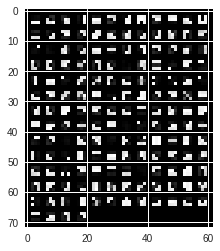

In [374]:
r=sd['module.block1.layer.1.lateral1.my_fun.weight']
grid = torchvision.utils.make_grid(r.cpu().repeat(1,3,1,1),nrow=int(sqrt(r.shape[0])))
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [313]:
[f for f in sd.keys() if 'fun' in f]
    #if 'myfun' in f:
    #    print f

['module.lateral1.my_fun.weight',
 'module.block1.layer.0.lateral1.my_fun.weight',
 'module.block1.layer.0.lateral2.my_fun.weight',
 'module.block1.layer.1.lateral1.my_fun.weight',
 'module.block1.layer.1.lateral2.my_fun.weight',
 'module.block1.layer.2.lateral1.my_fun.weight',
 'module.block1.layer.2.lateral2.my_fun.weight',
 'module.block1.layer.3.lateral1.my_fun.weight',
 'module.block1.layer.3.lateral2.my_fun.weight',
 'module.block2.layer.0.lateral1.my_fun.weight',
 'module.block2.layer.0.lateral2.my_fun.weight',
 'module.block2.layer.1.lateral1.my_fun.weight',
 'module.block2.layer.1.lateral2.my_fun.weight',
 'module.block2.layer.2.lateral1.my_fun.weight',
 'module.block2.layer.2.lateral2.my_fun.weight',
 'module.block2.layer.3.lateral1.my_fun.weight',
 'module.block2.layer.3.lateral2.my_fun.weight',
 'module.block3.layer.0.lateral1.my_fun.weight',
 'module.block3.layer.0.lateral2.my_fun.weight',
 'module.block3.layer.1.lateral1.my_fun.weight',
 'module.block3.layer.1.lateral2.my

In [31]:
#z.groupby(['dataset','lateral','let_inhibition_learn']).max()

index  Learning Rate  Train Loss  \
dataset lateral let_inhibition_learn                                     
10      default False                    24            0.1    1.477901   
                True                     24            0.1    1.337913   
        none    False                    24            0.1    1.683257   
100     default False                    24            0.1    3.743640   
                True                     24            0.1    3.673698   
        none    False                    24            0.1    4.012393   

                                      Valid Loss  Train Acc.  Valid Acc.  \
dataset lateral let_inhibition_learn                                       
10      default False                   1.240327      87.624       84.56   
                True                    0.961783      91.156       88.69   
        none    False                   1.495572      89.930       87.26   
100     default False                   3.323889      72.008       63.55   
                True                    3.191444      73.488       65.19   
        none    False                   3.998455      70.706       62.91   

                                       arch  
dataset lateral let_inhibition_learn         
10      default False                   wrn  
                True                  dense  
        none    False                   wrn  
100     default False                   wrn  
                True                    wrn  
        none    False                   wrn

In [150]:

a[0]['flines']

'0.100000\t2.891201\t2.842624\t26.512000\t28.330000\t\n'

In [146]:

#pd.read_table(a[0]['flines'])

ValueError: Invalid file path or buffer object type: <type 'list'>

( python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar100_inhibition/wrn-28-10-IN_default_IL_False-run_0                        --lateral-inhibition default --learn-inhibition False --dataset cifar100  --gpu_id 0  ; python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_False-run_0                        --lateral-inhibition default --learn-inhibition False --dataset cifar10  --gpu_id 0  ; python cifar.py -a densenet --depth 100 --growthRate 12                        --train-batch 64 --epochs 300 --schedule 150 225 --wd 1e-4                        --gamma 0.1 --checkpoint ~/checkpoints/cifar100_inhibition/densenet-bc-100-12-IN_default_IL_True-run_0                 

In [117]:
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


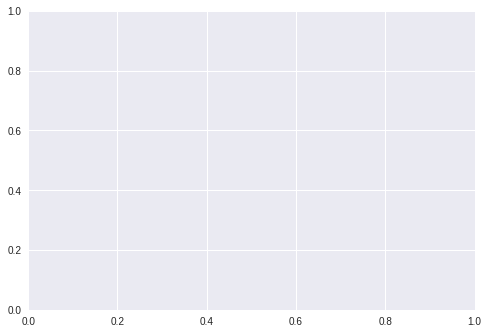

In [126]:
sns.set_palette(sns.color_palette("Set1"))
for n,p in zip(names,perfs):
    #p=np.maximum.accumulate(p)
    #if len(p) != epochs:
    #    continue
    z=0
    plot(p[z:z+50],label=n)
#ylim(90,96)
legend()

In [204]:
cmd

'python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint /home/amir/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default-run_2        --lateral-inhibition default'

In [203]:
print curOutDir

/home/amir/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default-run_2


In [199]:
cmd

'python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint default        --lateral-inhibition default'

In [110]:
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = z(X,Y)

In [98]:
Z = Z-Z.mean()

In [ ]:
# Let's define two gaussians.

In [94]:
Z.sum()

0.025671842599306084

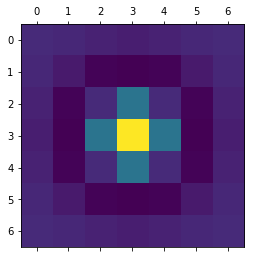

In [109]:
matshow(Z)

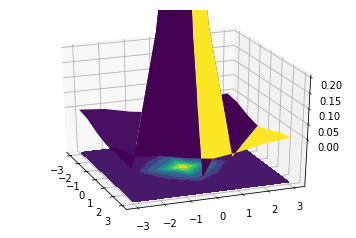

In [111]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
               cmap=cm.viridis)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

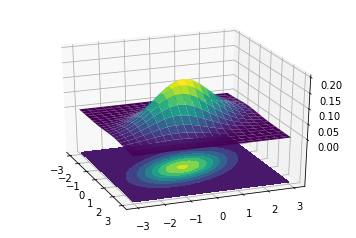

In [18]:
# import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

In [8]:
!mkdir ca_frames

0/400
10/400
20/400
30/400
40/400
50/400
60/400
70/400
80/400
90/400
100/400
110/400
120/400
130/400
140/400
150/400
160/400
170/400
180/400
190/400
200/400
210/400
220/400
230/400
240/400
250/400
260/400
270/400
280/400
290/400
300/400
310/400
320/400
330/400
340/400
350/400
360/400
370/400
380/400
390/400


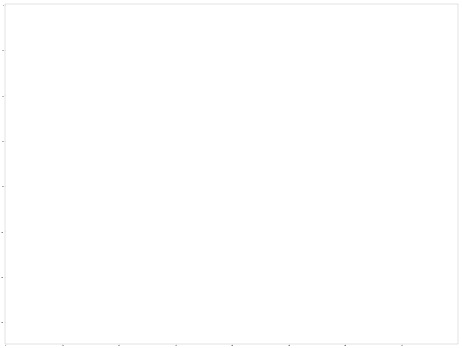

In [9]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def ca_step(X):
    """Evolve the maze by a single CA step."""

    K = np.ones((3, 3))
    n = convolve2d(X, K, mode='same', boundary='wrap') - X
    return (n == 3) | (X & ((n > 0) & (n < 6)))

# Maze size
nx, ny = 200, 150
X = np.zeros((ny, nx), dtype=np.bool)
# Size of initial random area (must be even numbers)
mx, my = 20, 16

# Initialize a patch with a random mx x my region
r = np.random.random((my, mx)) > 0.75
X[ny//2-my//2:ny//2+my//2, nx//2-mx//2:nx//2+mx//2] = r

# Total number of iterations
nit = 400
# Make an image every ipf iterations
ipf = 10

# Figure dimensions (pixels) and resolution (dpi)
width, height, dpi = 600, 450, 10
fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
ax = fig.add_subplot(111)

for i in range(nit):
    X = ca_step(X)
    if not i % ipf:
        print('{}/{}'.format(i,nit))
        im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
        plt.savefig('ca_frames/_img{:04d}.png'.format(i), dpi=dpi)
        plt.cla()